# Survival Prediction After Thoracic Surgeries

[Link to Dataset](https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data)  
[Link to Relevant Research Paper](https://www.sciencedirect.com/science/article/abs/pii/S1568494613002627)

## Table of Contents  
1. [Modelling the Solution](#S1)<br>
    1.1 [Clamp Transformation](#S1.1)<br>
    1.2 [Preparing the Data](#S1.2)<br>
    1.3 [Preparing for Performance Measurements](#S1.3)<br>
    1.4 [Standard Classifiers](#S1.4)<br>
    1.5 [Cost Sensitive Learning](#S1.5)<br>
    1.6 [Sampling Methods](#S1.6)<br>
    1.7 [Comparison](#S1.7)<br>
2. [The Evaluation in Production](#S2)<br>
3. [Conclusion and Recommendations](#S3)<br>

## <a name="S1"></a>Section 1: Modelling the Solution

#### Proposed Solutions

The two proposals from part 1 of the assignment are as below.

__Prposal 1: Surgery Prediction__<br>
A model could be built to predict the likelihood that a patient will survive for more than 1 year after the surgery has been performed. This model could be used to assign every surgery a 1 year survival likelihood, and those that are most likely to lead to death within 1 year could be flagged for the healthcare providers to pay closer attention during postoperative recovery and follow-up appointments. In this way the healthcare providers can get ahead of detereorations, or be informed to react to detereorations as quickly as possible, for those who are at higher risks of dying within a year of surgery.

__Proposal 2: Treatment Prediction__<br>
A model could be built to predict the likelihood of patient survival after 1 year from surgery when creating treatment plans. This model could be run when patients are diagnosed with lung cancer to assign a 1 year survival likelihood if they had a surgery, and flag those with higher risks to healthcare providers when determining the best course of treatment. Using this model, the healthcare providers will have an extra information in decision making and comminicating to patients if surgeries are their best options and inform them of the risks.

They both relate to predicting the likelihood of a patient surviving more than 1 year after a thoracic surgery has been performed. In part 2 of the assignment, we will aim to find the best model that serves both proposals based on the data available to us from `ThoraricSurgery.arff`.

#### Importing Libraries

We will first import the required libraries.

In [1]:
# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.style import set_palette, color_palette
set_palette('yellowbrick')

#### Loading the Data

We will then load the the data file `ThoraricSurgery.arff`. The data section has no headers, so we will create a list of headers and specify it when reading the data file.  

In [2]:
# Headers for the data file
headers = ['DGN', 'PRE4', 'PRE5', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'AGE', 'Risk1Yr']

# Read the data part of ThoraricSurgery.arff
df = pd.read_csv('ThoraricSurgery.arff', sep = ',', names = headers, skiprows = 21)

In [3]:
# Inspect the first few lines of the dataset
df.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
1,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
2,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
3,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
4,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T


In [4]:
# Summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DGN      470 non-null    object 
 1   PRE4     470 non-null    float64
 2   PRE5     470 non-null    float64
 3   PRE6     470 non-null    object 
 4   PRE7     470 non-null    object 
 5   PRE8     470 non-null    object 
 6   PRE9     470 non-null    object 
 7   PRE10    470 non-null    object 
 8   PRE11    470 non-null    object 
 9   PRE14    470 non-null    object 
 10  PRE17    470 non-null    object 
 11  PRE19    470 non-null    object 
 12  PRE25    470 non-null    object 
 13  PRE30    470 non-null    object 
 14  PRE32    470 non-null    object 
 15  AGE      470 non-null    int64  
 16  Risk1Yr  470 non-null    object 
dtypes: float64(2), int64(1), object(14)
memory usage: 62.5+ KB


### <a name="S1.1"></a>1.1 Clamp Transformation

As we have established in part 1 of the assignment, `PRE5` is a unimodal distribution with several high outliers. Those outliers, such as the maximum FEV1 value of 86.3, are unlikely to be representative of human lung capacities. 

In [5]:
# Describe 'PRE5' only
df['PRE5'].describe()

count    470.000000
mean       4.568702
std       11.767857
min        0.960000
25%        1.960000
50%        2.400000
75%        3.080000
max       86.300000
Name: PRE5, dtype: float64

We have planned for a clamp transformation and calculated the clamp threshold as the 3rd quartile plus 1.5 times the inter-quartile range.  
  
$upper = 3.08 + 1.5 × (3.08 - 1.96) = 4.76$ 

In [6]:
# Replace 'PRE5' values above the clamp threshold with 4.76
df.loc[df.PRE5 > 4.76, 'PRE5'] = 4.76

<AxesSubplot:xlabel='PRE5', ylabel='Count'>

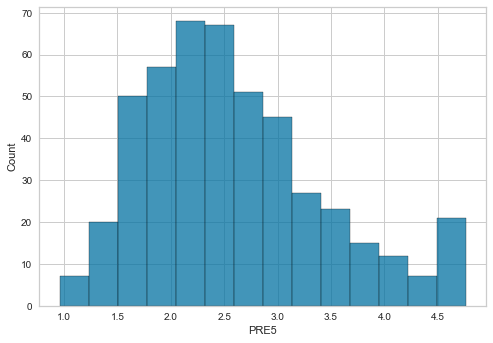

In [7]:
# Visualise the distribution of 'PRE5' after the clamp transformation
sns.histplot(x='PRE5', data=df)

### <a name="S1.2"></a>1.2 Preparing the Data

Data handling strategies planned in part 1 of the assignment are completed. Now we will split the dataset into a variable containing all features (X) and a variable containing the target (y).

In [8]:
X = df[df.columns[0:-1]]
y = df['Risk1Yr']

We will then transform the categorical features into one-hot-representation, and fit the numerical values in the [0, 1] range.

In [9]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Create lists of categorical and numerical column names
categorical_columns = ['DGN', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32']
numerical_columns = ['PRE4', 'PRE5', 'AGE']

# Encode categorical features as one-hot numeric arrays
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X[categorical_columns])

# Concatenate the continuous and categorical features into one dataset
x_all = np.concatenate([X[numerical_columns].to_numpy(),
                          one_hot_encoder.transform(X[categorical_columns]).toarray()],
                         axis=1)

# Transform numerical features by scaling each feature to [0, 1] range
scaler = MinMaxScaler()
scaler.fit(x_all)
x_all = scaler.transform(x_all)
x_all.shape

(470, 37)

We will also use `LabelEncoder` to encode levels of the target feature.

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)

### <a name="S1.3"></a>1.3 Preparing for Performance Measurements

Considering the size of the dataset and the moderate imbalance in the target dataset, types of experiments and relevant metrics suggested in part 1 of the assignment were as below.

* Use k-fold cross validation with $k=5$
* Plot confusion matrix
* Cauculate average class accuracy based on harmonic means
* Plot ROC curves to visually compare multiple modeling techniques

Our plan is to set up two empty arrays for each model we train, loop through every fold of the of the 5 cross-validation data folds, and  store the test and predicted values of `y` in the arrays. We can then use those arrays to plot confusion matrix, calculate avarage class accuracy based on harmonic mean, and plot ROC curve representing all 5 folds of cross-validation.

We will first set up the variables to perform k-fold cross validation with $k=5$

In [11]:
from sklearn.model_selection import KFold

# Specify number of folds, random_state, and shuffle
k = 5
kf = KFold(n_splits = k, random_state = 42, shuffle = True)

We will then create a function to calculate average class accuracy based on a harmonic mean.

In [12]:
from sklearn.metrics import recall_score

def harmonic_mean (y_test_array, y_pred_array):
    recall_t = recall_score(y_test_array, y_pred_array, pos_label = 1)
    recall_f = recall_score(y_test_array, y_pred_array, pos_label = 0)
    hm = 1 / (1/2 * ((1/recall_t) + (1/recall_f)))
    hm = round(hm, 3)
    return hm

We will also create an empty dataframe for storing the  average class accuracy based on a harmonic mean, false positive rates, true positive rates, area under the ROC curve, and visualisation object for confusion matrix.

In [13]:
roc_df = pd.DataFrame(columns = ['model', 'hm', 'fpr', 'tpr', 'auc', 'disp'])
roc_df

,model,hm,fpr,tpr,auc,disp


Since we will be training models and recording their performance measurements multiple times, we will also create a function to perform those steps.

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

def training (x, y, classifier):
    
    # Set up two arrays for storing the test and predicted values of y
    test_array = np.empty(0)
    pred_array = np.empty(0)
    
    # Loop through every fold, train a model, and concatenate y_test and y_pred to arrays
    for train_index, test_index in kf.split(x):

        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

        model = classifier
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        test_array = np.append(test_array, y_test)
        pred_array = np.append(pred_array, y_pred)

    # Visualise one confusion matrix representing all 5 cross-validation data folds
    disp = ConfusionMatrixDisplay(confusion_matrix(test_array, pred_array))

    # Calculate the average class accuracy based on a harmonic mean
    avg_class_accuracy = harmonic_mean(test_array, pred_array)

    # Append the false positive rates, true positive rates, and ROC scores to roc_df
    fpr, tpr, thresholds = roc_curve(test_array, pred_array)
    auc = roc_auc_score(test_array, pred_array)
    auc = round(auc, 3)
    
    return (disp, avg_class_accuracy, fpr, tpr, auc)

We will also create a function for visualising ROC curves.

In [15]:
def plot_roc (df):

    # Set the size of the visualisation
    fig = plt.figure(figsize=(8,6))

    # Plot ROC curves
    for index, row in df.iterrows():

        plt.plot(tuple(df.loc[index]['fpr']), 
                 tuple(df.loc[index]['tpr']), 
                 label= f"{df.loc[index]['model']}, AUC={df.loc[index]['auc']}")

    # Configure stylings
    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=10)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=10)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=10)
    plt.legend(prop={'size':10}, loc='lower right')

    plt.show()

### <a name="S1.4"></a>1.4 Standard Classifiers

Since the dataset has discrete class labels of `T` and `F`, and not continuous quantities, we will try the four classification methods below. We will first do this without any corrections for the dataset imbalance to see how the imbalance affects the model performances.

* Decision Tree Classifier
* K-Neighbors Classifier
* Support Vector Classification (SVC)
* K-Means Clustering

#### Decision Tree Classifier

Here we will train a model using the decision tree algorithm from information-based learning.

Average class accuracy (harmonic mean): 0.362


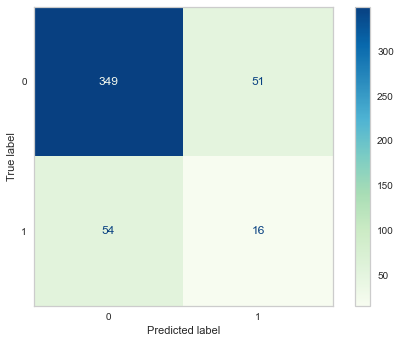

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Run training function
disp_dt, hm_dt, fpr_dt, tpr_dt, auc_dt = training(x_all, y, DecisionTreeClassifier())

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_dt.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_dt}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'DecisionTreeClassifier', 'hm':hm_dt, 'fpr':fpr_dt, 'tpr':tpr_dt, 'auc':auc_dt, 'disp':disp_dt}, ignore_index = True)

As expected, the model struggles to predict the `T` labels (encoded to `1` here) since it's a smaller fraction of the original dataset compared to `F`.

#### K-Neighbors Classifier

We will now run the K-nearest neighbours with $k = 3$. We will aim to keep the $k$ value low, because with an imbalanced dataset, as $k$ increases, the majority target level will begin to dominate the feature space. Since we have a binary classification problem, we will choose an odd number for $k$ to avoids tied votes.

Average class accuracy (harmonic mean): 0.082


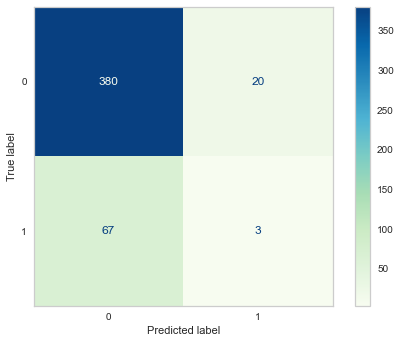

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Run training function
disp_knn, hm_knn, fpr_knn, tpr_knn, auc_knn = training(x_all, y, KNeighborsClassifier(n_neighbors=3))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_knn.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_knn}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KNeighborsClassifier', 'hm':hm_knn, 'fpr':fpr_knn, 'tpr':tpr_knn, 'auc':auc_knn, 'disp':disp_knn}, ignore_index = True)

The average class accuracy (harmonic mean) is significantly lower compared to Decision Tree Classifier. The confusion matrix shows that the model is able to train a higher number of `F` labels (encoded to `0` here) correctly, but an extremely low number of `T`.

#### Support Vector Classification

For SVC, we will set `kernel = 'poly'` to use a non linear hyper-plane to separate the data, but leave `gamma` as default (`'scale'`) to avoid overfitting that occurs with higher `gamma` values. We will run the model with regularization parameters `1`, `10`, `25`, `50`, and `100` and compare their average class accuracies (harmonic mean) to see which of the five is the optimal parameter for `C`.

In [18]:
from sklearn.svm import SVC

cs = [1, 10, 25, 50, 100]

for c in cs:
    disp_svc, hm_svc, fpr_svc, tpr_svc, auc_svc = training(x_all, y, SVC(C=c, kernel='poly'))
    roc_df = roc_df.append({'model':'SVC, C=' + str(c), 'hm':hm_svc,'fpr':fpr_svc, 'tpr':tpr_svc, 'auc':auc_svc, 'disp':disp_svc}, ignore_index = True)

In [19]:
roc_df.loc[roc_df['model'].isin(['SVC, C=1','SVC, C=10', 'SVC, C=25', 'SVC, C=50', 'SVC, C=100']),['model', 'hm']]

,model,hm
2,"SVC, C=1",0.082
3,"SVC, C=10",0.269
4,"SVC, C=25",0.329
5,"SVC, C=50",0.289
6,"SVC, C=100",0.247


Out of the five regularization parameters we have tried, $C = 25$ has returned the highest average class accuracy (harmonic mean). We will plot the confusion matrix for $C = 25$ to compare with the other models.

Average class accuracy (harmonic mean): 0.329


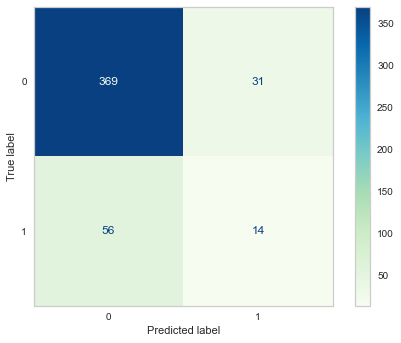

In [20]:
svc_cm = roc_df.loc[roc_df['model'] == 'SVC, C=25', 'disp'].values
np.take(svc_cm, 0).plot(cmap = 'GnBu')
plt.grid(False)
print(f"Average class accuracy (harmonic mean): {np.take(roc_df.loc[roc_df['model'] == 'SVC, C=25',['hm']].values, 0)}")

The ability to predict `F` labels is comparable to Decision Tree Classifier.

#### K-Means Clustering

Before we run K-Means Clustering, we will use the elbow method to select the optimal number of clusters.

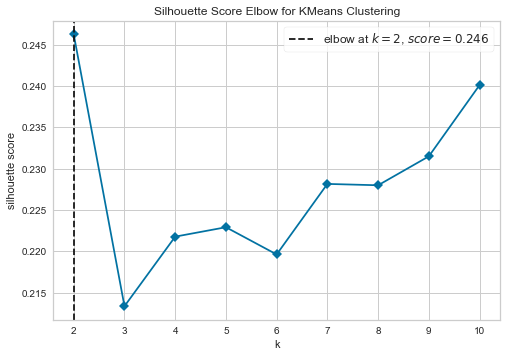

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11), timings=False, metric="silhouette")
visualizer.fit(x_all)
visualizer.show() 

Above graph shows $k = 2$ as the optimal value. We will now run the K-Means Clustering with $k = 2$.

Average class accuracy (harmonic mean): 0.456


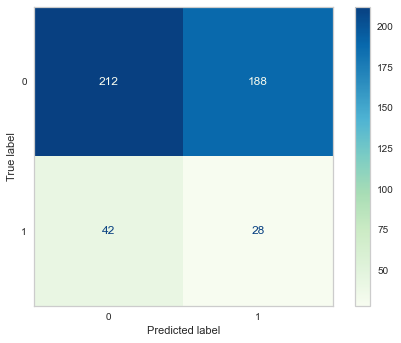

In [22]:
# Run training function
disp_kmeans, hm_kmeans, fpr_kmeans, tpr_kmeans, auc_kmeans = training(x_all, y, KMeans(n_clusters=2))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_kmeans.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_kmeans}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KMeans', 'hm':hm_kmeans, 'fpr':fpr_kmeans, 'tpr':tpr_kmeans, 'auc':auc_kmeans, 'disp':disp_kmeans}, ignore_index = True)

Average class accuracy (harmonic mean) is the highest so far, but there is an extremely high number `F` labels predicted as `T` (False Positives).

Below is a summary of average class accuracies (harmonic mean) from the four models.

In [23]:
# Create a subset of roc_df
standard_models = {'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVC, C=25', 'KMeans'}
standard_roc_df = roc_df.loc[roc_df['model'].isin(standard_models),:]
standard_roc_df.loc[:, ['model', 'hm']]

,model,hm
0,DecisionTreeClassifier,0.362
1,KNeighborsClassifier,0.082
4,"SVC, C=25",0.329
7,KMeans,0.456


We will also plot the ROC curves to compare their performances.

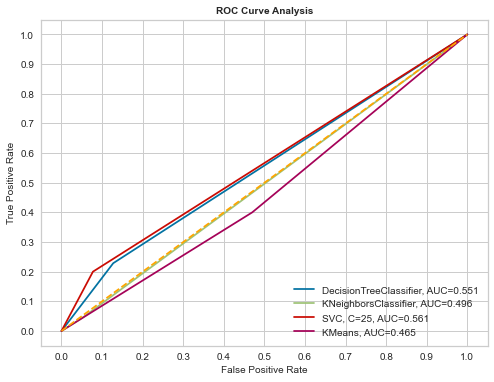

In [24]:
# Plot ROC curves for standard_roc_df
plot_roc(standard_roc_df)

So far, we can observe that the all standard classifiers have difficulties with the imbalanced dataset without any corrections. The ROC curve for `KMeans` occasionally appears slightly under the diagonal line for $TPR = FPR$ due to their high False Positive predictions, showing predictions opposite to the labels.

### <a name="S1.5"></a>1.5 Cost Sensitive Learning

Of the four algorithms in section 1.4, `DecisionTreeClassifier` and `SVC` allows us to explore cost-sensitive learning using `class_weight`. We will run both with `class_weight = 'balanced'` and see if it improves the model performances.

#### Decision Tree Classifier with Cost-Sensitive Learning

Average class accuracy (harmonic mean): 0.306


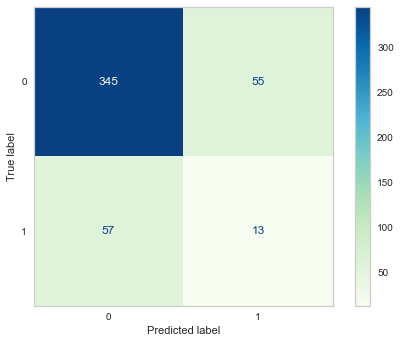

In [25]:
# Run training function
disp_dt_cs, hm_dt_cs, fpr_dt_cs, tpr_dt_cs, auc_dt_cs = training(x_all, y, DecisionTreeClassifier(class_weight='balanced'))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_dt_cs.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_dt_cs}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'DecisionTreeClassifier, Balanced', 'hm':hm_dt_cs, 'fpr':fpr_dt_cs, 'tpr':tpr_dt_cs, 'auc':auc_dt_cs, 'disp':disp_dt_cs}, ignore_index = True)

Average class accuracy (harmonic mean) for `DecisionTreeClassifier` has decreased with `class_weight = 'balanced'`.

#### Support Vector Classification with Cost-Sensitive Learning

Average class accuracy (harmonic mean): 0.431


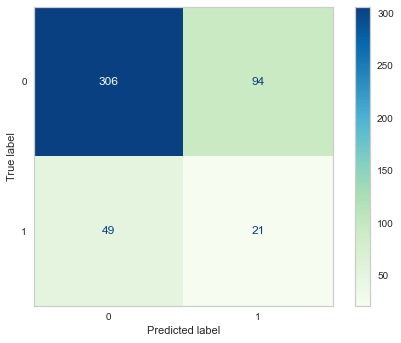

In [26]:
# Run training function
disp_svc_cs, hm_svc_cs, fpr_svc_cs, tpr_svc_cs, auc_svc_cs = training(x_all, y, SVC(C=25, kernel='poly', class_weight='balanced'))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_svc_cs.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_svc_cs}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'SVC, Balanced', 'hm':hm_svc_cs, 'fpr':fpr_svc_cs, 'tpr':tpr_svc_cs, 'auc':auc_svc_cs, 'disp':disp_svc_cs}, ignore_index = True)

Using `class_weight = 'balanced'` has increased the Average class accuracy (harmonic mean) of `SVC`.

We will also compare the areas under the receiver operating characteristic curve below.

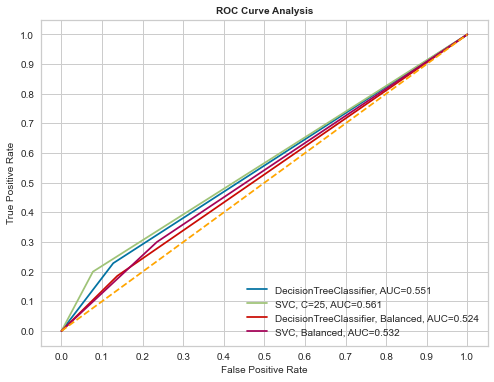

In [27]:
# Create a subset of roc_df
balanced_models = {'DecisionTreeClassifier', 'DecisionTreeClassifier, Balanced', 'SVC, C=25', 'SVC, Balanced'}
balanced_roc_df = roc_df.loc[roc_df['model'].isin(balanced_models),:]

# Plot the ROC curves
plot_roc(balanced_roc_df)

Areas under the ROC curve have decreased for both `DecisionTreeClassifier` and `SVC` with use of `class_weight = 'balanced'`.

### <a name="S1.6"></a>1.6 Sampling Methods

In this section, we will experiment with a few sampling methods in order to correct the imbalance, .

Since the dataset has 470 instances, of which 70 of them have target level `T`, we will not be using undersampling methods at this time. This is because undersampling will bring the the size of the total dataset down to 140, which would be too small for the evaluation method we're using in this assignment, k-fold cross validation.

From oversampling methods available from `imblearn`, we will try:
* Random Oversampling
* Synthetic Minority Oversampling Technique (SMOTE)
* Adaptive Synthetic (ADASYN)

#### Decision Tree Classifier with Random Oversampling

First, we will generate new samples by randomly sampling with replacement from the current available samples.

In [28]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Generate new samples by using RandomOverSampler
ros = RandomOverSampler(random_state=0)
x_random, y_random = ros.fit_resample(x_all, y)
print(sorted(Counter(y_random).items()))

[(0, 400), (1, 400)]


We will then run `DecisionTreeClassifier` using the the dataset created with `RandomOverSampler`.

Average class accuracy (harmonic mean): 0.925


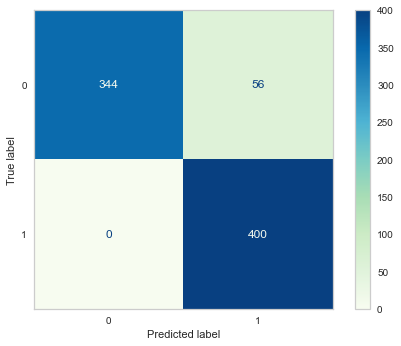

In [29]:
# Run training function for DecisionTreeClassifier using x_random and y_random
disp_random_dt, hm_random_dt, fpr_random_dt, tpr_random_dt, auc_random_dt = training(x_random, y_random, DecisionTreeClassifier())

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_random_dt.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_random_dt}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'DecisionTreeClassifier, Random', 'hm':hm_random_dt, 'fpr':fpr_random_dt, 'tpr':tpr_random_dt, 'auc':auc_random_dt, 'disp':disp_random_dt}, ignore_index = True)

`RandomOverSampler` has increased the average class accuracy (harmonic mean) of `DecisionTreeClassifier` significantly, with all of `T` labels predicted correctly.

#### Decision Tree Classifier with SMOTE

We will now generate samples by selecting examples that are close in feature space, drawing a line between the examples, and drawing a new sample at a point along the line.

In [30]:
from imblearn.over_sampling import SMOTE

# Generate new samples by using SMOTE
x_smote, y_smote = SMOTE().fit_resample(x_all, y)
print(sorted(Counter(y_smote).items()))

[(0, 400), (1, 400)]


We will run `DecisionTreeClassifier` using the the dataset created with `SMOTE`.

Average class accuracy (harmonic mean): 0.807


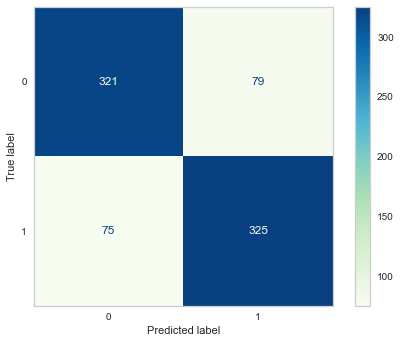

In [31]:
# Run training function
disp_smote_dt, hm_smote_dt, fpr_smote_dt, tpr_smote_dt, auc_smote_dt = training(x_smote, y_smote, DecisionTreeClassifier())

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_smote_dt.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_smote_dt}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'DecisionTreeClassifier, SMOTE', 'hm':hm_smote_dt, 'fpr':fpr_smote_dt, 'tpr':tpr_smote_dt, 'auc':auc_smote_dt, 'disp':disp_smote_dt}, ignore_index = True)

Average class accuracy (harmonic mean) has increased using `SMOTE`, but not as much as it did with `RandomOverSampler`.

#### Decision Tree Classifier with ADASYN

Lastly, we will generate samples according to the level of difficulty inlearning particular minority class observations.

In [32]:
from imblearn.over_sampling import ADASYN

x_adasyn, y_adasyn = SMOTE().fit_resample(x_all, y)

print(sorted(Counter(y_adasyn).items()))

[(0, 400), (1, 400)]


We will run `DecisionTreeClassifier` using the the dataset created with `ADASYN`.

Average class accuracy (harmonic mean): 0.82


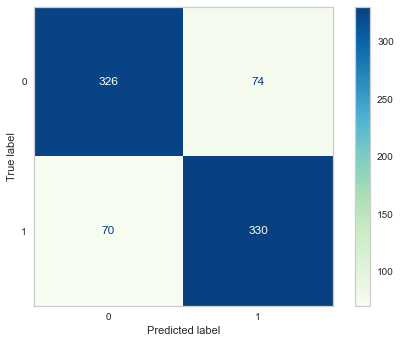

In [33]:
# Run training function
disp_adasyn_dt, hm_adasyn_dt, fpr_adasyn_dt, tpr_adasyn_dt, auc_adasyn_dt = training(x_adasyn, y_adasyn, DecisionTreeClassifier())

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_adasyn_dt.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_adasyn_dt}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'DecisionTreeClassifier, ADASYN', 'hm':hm_adasyn_dt, 'fpr':fpr_adasyn_dt, 'tpr':tpr_adasyn_dt, 'auc':auc_adasyn_dt, 'disp':disp_adasyn_dt}, ignore_index = True)

Again, the average class accuracy (harmonic mean) has increased using `ADASYN`, but not as much as it did with `RandomOverSampler`.

We will also plot the the ROC curves for all `DecisionTreeClassifier` variations we have seen so far for comparison.

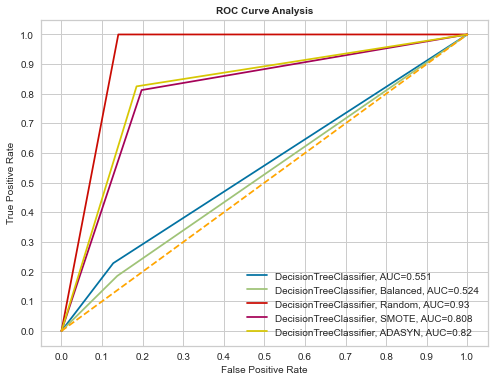

In [34]:
# Create a subset of roc_df
dt_models = {'DecisionTreeClassifier', 'DecisionTreeClassifier, Balanced', 'DecisionTreeClassifier, Random', 'DecisionTreeClassifier, SMOTE', 'DecisionTreeClassifier, ADASYN'}
dt_roc_df = roc_df.loc[roc_df['model'].isin(dt_models),:]

# Plot the ROC curves
plot_roc(dt_roc_df)

Similarly to average class accuracy (harmonic mean), we can see that oversampling methods have improved the model performance in area under ROC curve. `RandomOverSampler` has scored the best.

#### K-Nearest Neighbors with Random Oversampling

We will run `KNeighborsClassifier` using the the dataset created with `RandomOverSampler`.

Average class accuracy (harmonic mean): 0.859


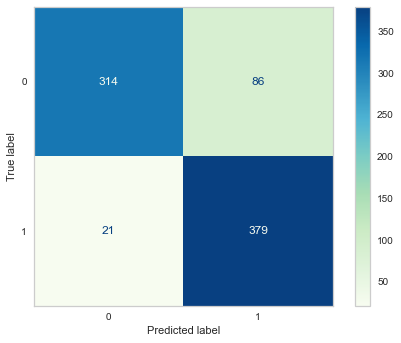

In [35]:
# Run training function for KNeighborsClassifier using x_random and y_random
disp_random_knn, hm_random_knn, fpr_random_knn, tpr_random_knn, auc_random_knn = training(x_random, y_random, KNeighborsClassifier(n_neighbors=3))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_random_knn.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_random_knn}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KNeighborsClassifier, Random', 'hm':hm_random_knn, 'fpr':fpr_random_knn, 'tpr':tpr_random_knn, 'auc':auc_random_knn, 'disp':disp_random_knn}, ignore_index = True)

Compared to average class accuracy (harmonic mean) from the standard K-Nearest Neighbors, which was under 0.1, `RandomOverSampler` has increased the model performance significantly.

#### K-Nearest Neighbors with SMOTE

We will run `KNeighborsClassifier` using the the dataset created with `SMOTE`.

Average class accuracy (harmonic mean): 0.822


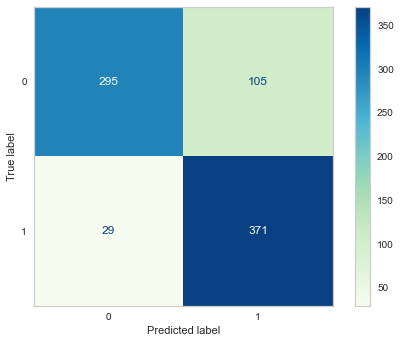

In [36]:
# Run training function
disp_smote_knn, hm_smote_knn, fpr_smote_knn, tpr_smote_knn, auc_smote_knn = training(x_smote, y_smote, KNeighborsClassifier(n_neighbors=3))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_smote_knn.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_smote_knn}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KNeighborsClassifier, SMOTE', 'hm':hm_smote_knn, 'fpr':fpr_smote_knn, 'tpr':tpr_smote_knn, 'auc':auc_smote_knn, 'disp':disp_smote_knn}, ignore_index = True)

Average class accuracy (harmonic mean) has increased using `SMOTE`, but not as much as it did with `RandomOverSampler`.

#### K-Nearest Neighbors with ADASYN

We will run `KNeighborsClassifier` using the the dataset created with `ADASYN`.

Average class accuracy (harmonic mean): 0.798


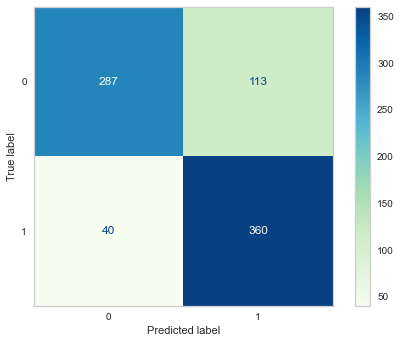

In [37]:
# Run training function
disp_adasyn_knn, hm_adasyn_knn, fpr_adasyn_knn, tpr_adasyn_knn, auc_adasyn_knn = training(x_adasyn, y_adasyn, KNeighborsClassifier(n_neighbors=3))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_adasyn_knn.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_adasyn_knn}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KNeighborsClassifier, ADASYN', 'hm':hm_adasyn_knn, 'fpr':fpr_adasyn_knn, 'tpr':tpr_adasyn_knn, 'auc':auc_adasyn_knn, 'disp':disp_adasyn_knn}, ignore_index = True)

Again, the average class accuracy (harmonic mean) has increased using `ADASYN`, but not as much as it did with `RandomOverSampler`.

We will also plot the the ROC curves for all `KNeighborsClassifier` variations we have seen so far for comparison.

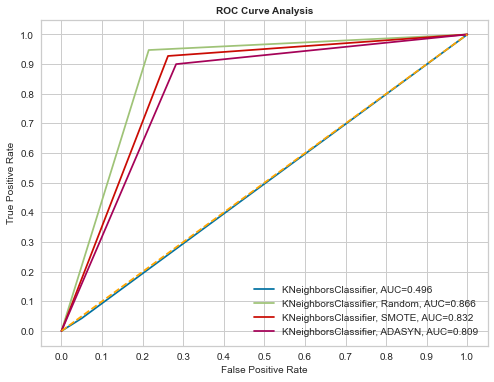

In [38]:
# Create a subset of roc_df
knn_models = {'KNeighborsClassifier', 'KNeighborsClassifier, Random', 'KNeighborsClassifier, SMOTE', 'KNeighborsClassifier, ADASYN'}
knn_roc_df = roc_df.loc[roc_df['model'].isin(knn_models),:]

# Plot the ROC curves
plot_roc(knn_roc_df)

Similar to `DecisionTreeClassifier`, the use of oversampling methods have significantly increased the model performace of `KNeighborsClassifier`, with `RandomOverSampler` has scoring the best out of three.

#### Support Vector Machines with Random Oversampling

We will run `SVC` using the the dataset created with `RandomOverSampler`.

Average class accuracy (harmonic mean): 0.801


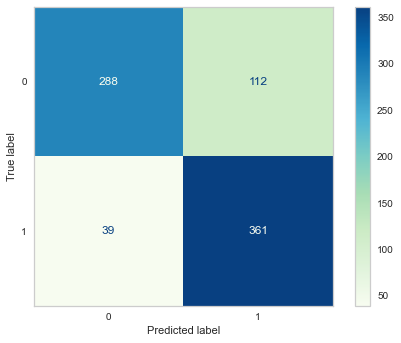

In [39]:
# Run training function for SVC using x_random and y_random
disp_random_svc, hm_random_svc, fpr_random_svc, tpr_random_svc, auc_random_svc = training(x_random, y_random, SVC(C=25, kernel='poly'))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_random_svc.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_random_svc}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'SVC, Random', 'hm':hm_random_svc, 'fpr':fpr_random_svc, 'tpr':tpr_random_svc, 'auc':auc_random_svc, 'disp':disp_random_svc}, ignore_index = True)

`RandomOverSampler` showed increase in average class accuracy (harmonic mean) compared to both standard `SVC` and one using `class_weight = 'balanced'`.

#### Support Vector Machines with SMOTE

We will run `SVC` using the the dataset created with `SMOTE`.

Average class accuracy (harmonic mean): 0.814


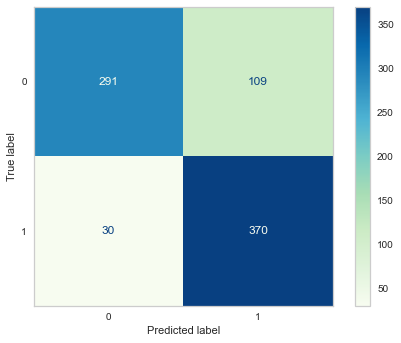

In [40]:
# Run training function
disp_smote_svc, hm_smote_svc, fpr_smote_svc, tpr_smote_svc, auc_smote_svc = training(x_smote, y_smote, SVC(C=25, kernel='poly'))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_smote_svc.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_smote_svc}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'SVC, SMOTE', 'hm':hm_smote_svc, 'fpr':fpr_smote_svc, 'tpr':tpr_smote_svc, 'auc':auc_smote_svc, 'disp':disp_smote_svc}, ignore_index = True)

`SMOTE` resulted in similar level of average class accuracy (harmonic mean) with `RandomOverSampler`.

#### Support Vector Machines with ADASYN

We will run `SVC` using the the dataset created with `ADASYN`.

Average class accuracy (harmonic mean): 0.814


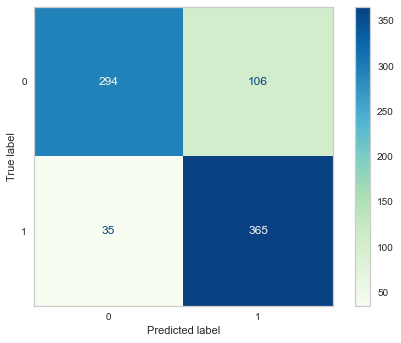

In [41]:
# Run training function
disp_adasyn_svc, hm_adasyn_svc, fpr_adasyn_svc, tpr_adasyn_svc, auc_adasyn_svc = training(x_adasyn, y_adasyn, SVC(C=25, kernel='poly'))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_adasyn_svc.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_adasyn_svc}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'SVC, ADASYN', 'fpr':fpr_adasyn_svc, 'hm':hm_adasyn_svc, 'tpr':tpr_adasyn_svc, 'auc':auc_adasyn_svc, 'disp':disp_adasyn_svc}, ignore_index = True)

`ADASYN` scored the highest in average class accuracy (harmonic mean) out of the three oversampling methods.

We will also plot the the ROC curves for all `SVC` variations we have seen so far for comparison.

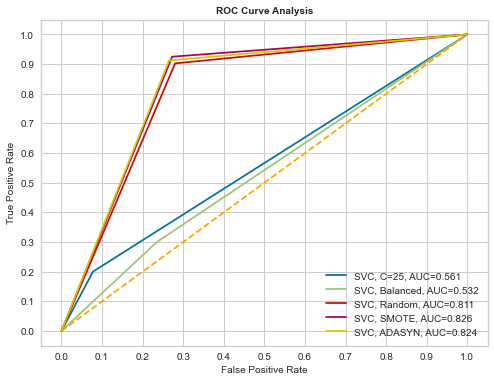

In [42]:
# Create a subset of roc_df
svc_models = {'SVC, C=25', 'SVC, Balanced', 'SVC, Random', 'SVC, SMOTE', 'SVC, ADASYN'}
svc_roc_df = roc_df.loc[roc_df['model'].isin(svc_models),:]

# Plot the ROC curves
plot_roc(svc_roc_df)

Area under the ROC curve are similar for all three oversampling methods, as they have shown significant increase in model performace compard to the standard `SVC` and with `class_weight = 'balanced'`.

#### K-Means Clustering with Random Oversampling

We will run `KMeans` using the the dataset created with `RandomOverSampler`.

Average class accuracy (harmonic mean): 0.495


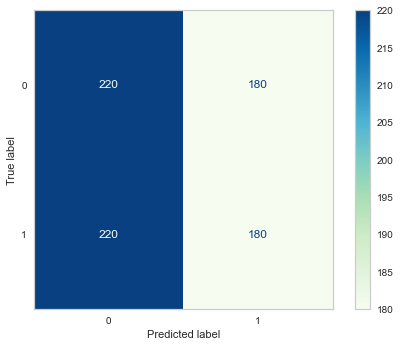

In [43]:
# Run training function for KMeans using x_random and y_random
disp_random_kmeans, hm_random_kmeans, fpr_random_kmeans, tpr_random_kmeans, auc_random_kmeans = training(x_random, y_random, KMeans(n_clusters=2))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_random_kmeans.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_random_kmeans}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KMeans, Random', 'hm':hm_random_kmeans, 'fpr':fpr_random_kmeans, 'tpr':tpr_random_kmeans, 'auc':auc_random_kmeans, 'disp':disp_random_kmeans}, ignore_index = True)

Contrary to the previous three models, `RandomOverSampler` did not a significant increase in model performance for `KMeans`. The number of False Positives remain extremely high.

#### K-Means Clustering with SMOTE

We will run `KMeans` using the the dataset created with `SMOTE`.

Average class accuracy (harmonic mean): 0.486


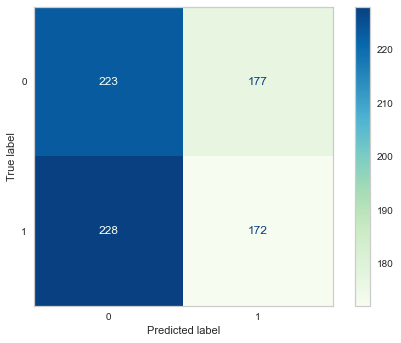

In [44]:
# Run training function
disp_smote_kmeans, hm_smote_kmeans, fpr_smote_kmeans, tpr_smote_kmeans, auc_smote_kmeans = training(x_smote, y_smote, KMeans(n_clusters=2))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_smote_kmeans.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_smote_kmeans}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KMeans, SMOTE', 'hm':hm_smote_kmeans, 'fpr':fpr_smote_kmeans, 'tpr':tpr_smote_kmeans, 'auc':auc_smote_kmeans, 'disp':disp_smote_kmeans}, ignore_index = True)

`SMOTE` also did not show significant improvement in model performance for `KMeans`. The number of False Positives are also still high.

#### K-Means Clustering with ADASYN

We will run `KMeans` using the the dataset created with `ADASYN`.

Average class accuracy (harmonic mean): 0.497


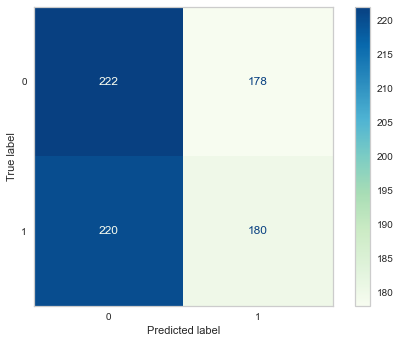

In [45]:
# Run training function
disp_adasyn_kmeans, hm_adasyn_kmeans, fpr_adasyn_kmeans, tpr_adasyn_kmeans, auc_adasyn_kmeans = training(x_adasyn, y_adasyn, KMeans(n_clusters=2))

# Plot confusion matrix and calculate avarage class accuracy based on harmonic means
disp_adasyn_kmeans.plot(cmap = 'GnBu')
plt.grid(False)
print(f'Average class accuracy (harmonic mean): {hm_adasyn_kmeans}')

# Append fpr, tpr, and auc to roc_df
roc_df = roc_df.append({'model':'KMeans, ADASYN', 'hm':hm_adasyn_kmeans, 'fpr':fpr_adasyn_kmeans, 'tpr':tpr_adasyn_kmeans, 'auc':auc_adasyn_kmeans, 'disp':disp_adasyn_kmeans}, ignore_index = True)

Similary to `RandomOverSampler` and `SMOTE`, the average class accuracy (harmonic mean) with `ADASYN` remains comparable to the standard `KMeans` without oversampling.

We will also plot the the ROC curves for all `KMeans` variations we have seen so far for comparison.

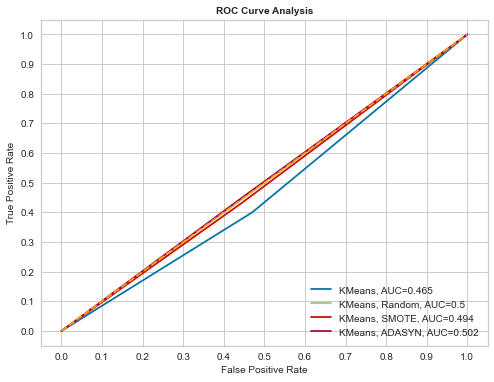

In [46]:
# Create a subset of roc_df
kmeans_models = {'KMeans', 'KMeans, Random', 'KMeans, SMOTE', 'KMeans, ADASYN'}
kmeans_roc_df = roc_df.loc[roc_df['model'].isin(kmeans_models),:]

# Plot the ROC curves
plot_roc(kmeans_roc_df)

Compared to other models, oversampling methods did not show significant improvement to the performance of `KMeans`.

### <a name="S1.7"></a>1.7 Comparison

The highest scoring models according to average class accuracy (harmonic mean) are as below.

In [47]:
# Order roc_df by hm
roc_df.loc[:, ['model', 'hm']].sort_values(by=['hm'], ascending=False).head()

,model,hm
10,"DecisionTreeClassifier, Random",0.925
13,"KNeighborsClassifier, Random",0.859
14,"KNeighborsClassifier, SMOTE",0.822
12,"DecisionTreeClassifier, ADASYN",0.820
18,"SVC, ADASYN",0.814


Visualising the highest scoring models according to areas under ROC curves.

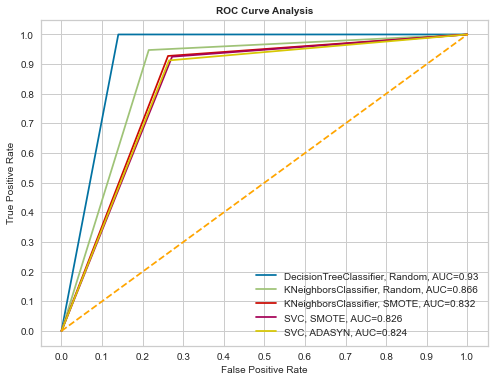

In [48]:
# Order roc_df by auc
top5_roc_df = roc_df.sort_values(by=['auc'], ascending=False).head()

# Plot the ROC curves
plot_roc(top5_roc_df)

`DecisionTreeClassifier` with `RandomOverSampler` has performed the best in both average class accuracy (harmonic mean) and area under the ROC curve. The confusion matrix showed all of `T` labels predicted correctly.

This should be applicable for both of the proposals documented in part 1 of the assignment, especially with an advantage that it does not produce any False Negatives. This is important for our proposals since False Negatives could mean that high-risk patients will not getting enough care from healthcare providers, which is a more dire consequence compared to having False Positives.

Although the oversampling methods used here increased the model performances significanly, they come with risks of overfitting. Recommendation for someone outside the project is to experiment with undersampling techniques in the future when the dataset grows to a size that allows them for k-fold cross validation. They could also experiment with undersampling techniques with the current dataset, which would bring down the total dataset size to 140, but use other cross validation methods that are suitable to smaller sample size, such as leave-one-out cross validation and bootstrapping cross validation. Tuning parameters for `DecisionTreeClassifier` may be useful in improving performance and avoiding overfitting.

## <a name="S2"></a>Section 2: The Evaluation in Production

As the medical technology advances, we expect the model to experience a concept drift at some point.

We would like to monitor model output distribution changes with stability index. This is because the nature of this dataset requires 1 year after surgery at most to confirm the correct target feature values, making it not suitable for monitoring changes in performance measures. Using stability index, we can start to investigate when the value of the stability index is between 0.1 and 0.25, and take corrective actions when it goes above 0.25.

Once the stability index exceeds 0.1 for investigation to start, we can compare the descriptive feature distribution change between the original dataset and at the time the model went stale. Out of the 16 features in the dataset, we have 13 descriptive features, of which 10 of them are binary between `T` and `F`. Although monitoring descriptive feature distribution change is generally recommended for small number of descriptive featuers less than 10, it may be useful for understanding what has changed, and what improvements will be required.

Given the sensitive nature of our dataset relating to patients' survivals, we expect performing comparative experiments using a control group to be challenging in real life. Although it is a helpful method in both evaluating the model performance and its impact on the original business problem, it would be up to subject matter experts to determine ethical qualities of using control groups in situations considering patients' survivals.

## <a name="S3"></a>Section 3: Conclusion and Recommendations

#### Conclusion

In part 2 of the assignment, we have experimented with the four different types of classification models below, since the dataset has discrete class labels of `T` and `F`.

* Decision Tree Classifier
* K-Neighbors Classifier
* Support Vector Classification (SVC)
* K-Means Clustering

Below are the evaluation methods we used.

* Use k-fold cross validation with $k=5$
* Plot confusion matrix
* Cauculate average class accuracy based on harmonic means
* Plot ROC curves to visually compare models

In an attempt to correct the data imbalance, we have tried the four methods below. We did not perform any undersampling at this time, since they would have brought the size of the total dataset down to 140, which would be too small for the evaluation method.

* Cost sensitive learning where setting `class_weight = 'balanced'` was available (`DecisionTreeClassifier` and `SVC`)
* Random Oversampling from `imblearn`
* Synthetic Minority Oversampling Technique (SMOTE) from `imblearn`
* Adaptive Synthetic (ADASYN) from `imblearn`

Our conclusion is that `DecisionTreeClassifier` with `RandomOverSampler` performed the best in both average class accuracy (harmonic mean) and area under the ROC curve, with confusion matrix showing all of `T` labels predicted correctly.

This model applies for both proposals documented in part 1 of the assignment, by providing an ability alert healthcare providers of patients who may have higher risks of leading to death within 1 year from surgery. Although the model produces a number of False Positives, the more important advantage is that it does not produce any False Negatives. False Negatives in this case could lead to high-risk patients not getting appropriate attention in both proposal 1 - post operative care and proposal 2 - in determining the best course of treatment, which are worse consequences than having False Positives where the patients may receive extra care.

The disadvantage of this model is that oversampling could lead to overfitting, so the results from this model should be used combined with subject matter expertese from healthcare providers. This is recommendation is true for all data analytics models, that humans should make the final decisions not the models. In our case for example, there are many factors that can affect patients' health that are not recorded in the dataset we had, hence this model cannot account for them. 

The model is also expected to have a concept drift as the medical technology advances. Since the target features cannot be confirmed until after 1 year of surgery, monitoring changes in performance measures will be a slow process. Due to the sensitivity of the subject around patients' survivals, performing comparative experiments using a control group is expected to be challenging as well.

#### Recommendation

* __Handling risks from oversampling__<br><br>
    Oversampling involves risks of overfitting by possibly adding datapoints generated based on noise. Since this dataset records the post-operative life expectancy in lung cancer patients, we can expect for the data imbalance to persist as the dataset grows in the future. The recommendation is to explore undersampling techniques when the dataset reaches a size that allows them.

    Another possibility is to perform undersampling techniques with the current dataset size, but use cross validation methods that are suitable to smaller sample size such as leave-one-out cross validation and bootstrapping cross validation, instead of k-fold cross validation that we used here.<br><br>
    
* __Tuning parameters__<br><br>
    In section 1.4 of this assignment we have explored different regularisation parameters for `SVC`, but not for any parameters in `DecisionTreeClassifier`. It may improve the model performance, or be useful in avoiding overfitting.<br><br>
    
* __Evaluation in production__<br><br>
    Once the model is deployed, we would like to monitor model output distribution changes with stability index. When the value of the stability index is between 0.1 and 0.25 we can start to investigate what has changed, and when it goes above 0.25 we can take corrective actions.

    For investigation, we can compare descriptive feature distribution change between the time when the model was built and the time when model went stale. Although we have 13 descriptive features, which is above general recommendation of 10 for comparing descriptive feature distribution change, it could be helpful to understand what needs to be improved.<br><br>
    
* __Human decision making__<br><br>
    As it is recommended for all data analytics models, be aware of limitations of predictive outcomes, and use human subject matter expertese to make the final decisions. There are many factors that can affect patients' health that are not recorded in the dataset used to train this model.